If you use conda, you will need to install the `graphviz` module with the command prompt:  
`conda install graphviz python-graphviz`  


With `pip`: ??? - > https://lmgtfy.com/?q=install+graphviz+pip

[Graphviz's user guide](https://graphviz.readthedocs.io/en/stable/manual.html)  
[Grapgviz's documentation](https://www.graphviz.org/doc/info/attrs.html)

In [28]:
import graphviz as gv # need graphviz-python
import pandas as pd
import numpy as np

# Paramètres

In [29]:
data_file = 'arbre_gen_data.xlsx'

In [30]:
fraternity_name = 'Fraternité XYZ'
tree_name = 'Arbre Fraternel'
chapter_name = 'Chapitre Test'

In [31]:
# Configuration of the bro's cells
statut_styles = {'Actif': 'bold',
                 'Actif spécial': 'bold, dashed',
                 'Hors du chapitre - Actif': '',
                 'Alumnus': 'bold',
                 'Hors du chapitre - Alumnus': '',
                 'Suspendu': 'bold',
                 'Hors Fraternité': 'bold, dotted',
                 'Inconnu': 'bold'}

# https://www.hexcolortool.com/#198000
statut_colors = {'Actif': '#004D00',
                 'Actif spécial': '#338033',
                 'Hors du chapitre - Actif': '#98B398',
                 'Alumnus': '#6C33B3',
                 'Hors du chapitre - Alumnus': '#A38CC0',
                 'Suspendu': '#dbd176',
                 'Hors Fraternité': '#c2504c',
                 'Inconnu': 'gray80'}

# Create tree

In [32]:
# Loading data files
df = pd.read_excel(data_file, sheet_name='Liste des membres',dtypes='')
df['Nom Complet'] = df['Nom Complet'].str.replace(', ', '\n')
df['Big'] = df['Big'].str.replace(', ', '\n')
df = df.set_index('Nom Complet')

any_unknown_bigs = pd.isnull(df.loc[~df['Session pledging'].isin(['Fondateur'])]['Big'].unique()).any()

rankdir = 'TB' # TB -> Top Bottom ; LR -> Left Right

dot = gv.Digraph()
dot.graph_attr['rankdir'] = rankdir
dot.graph_attr['label'] = "<<b><font point-size='32'> {fraternity} <br/> {tree}<br/>{chapter}<br/><br/><br/></font></b>>".format(fraternity=fraternity_name, 
                                                                                                                                 tree=tree_name, 
                                                                                                                                 chapter=chapter_name,)
dot.graph_attr['labelloc'] = 't'

# Create all nodes and add color, style
for session in df['Session pledging'].unique():
    dot.node(session)
    
for bro in df.index:
    statut = df.at[bro, 'Statut du membre']
    dot.node(bro, 
             style=statut_styles[statut],
             color=statut_colors[statut], 
             fontcolor=statut_colors[statut],
             shape='record') #style='filled', fillcolor='yellow')

# Session chronology
sd_session = gv.Digraph()
sessions = df['Session pledging'].unique()
for i, session in enumerate(sessions):
    if i + 1 == len(sessions):
        break # last session
    dot.edge(session, sessions[i+1])

# Links between little and big
for bro, row in df.iterrows():
    if row.Big != row.Big:  # nan
        if row['Session pledging'] == 'Fondateur':
            continue
        else:
            big = 'Unknown bigs'
    else:
        big = row.Big
    dot.edge(big, bro)
        
# Align all bros from the same pledging session
df = df.reset_index().set_index('Session pledging')

for session in df.index.unique():
    with dot.subgraph(name='Session_' + session) as sub:
        bros = df.loc[session]['Nom Complet']
        if isinstance(bros, str): bros = [bros]
        sub.graph_attr['rankdir'] = rankdir
        sub.attr(rank='same')
        sub.node(session)
        for bro in bros:
            sub.node(bro)
        if session == 'Fondateur' and any_unknown_bigs:
            sub.node('Unknown bigs')

# Legend
with dot.subgraph(name='cluster_legend') as sub:
    sub.attr(label='Statut des membres')
    
    
    for statut in df['Statut du membre'].unique():
        sub.node(statut.replace(' - ', '\n'),
                 style=statut_styles[statut],
                 color=statut_colors[statut], 
                 fontcolor=statut_colors[statut],
                 shape='record')

    sub.edge('Alumnus', 'Hors du chapitre\nAlumnus',color='#00000000')
    sub.edge('Actif', 'Hors du chapitre\nActif',color='#00000000')
    sub.edge('Suspendu', 'Hors Fraternité',color='#00000000')

In [33]:
dot.render(data_file.partition('.')[0] + '.gv')

'arbre_gen_data.gv.pdf'

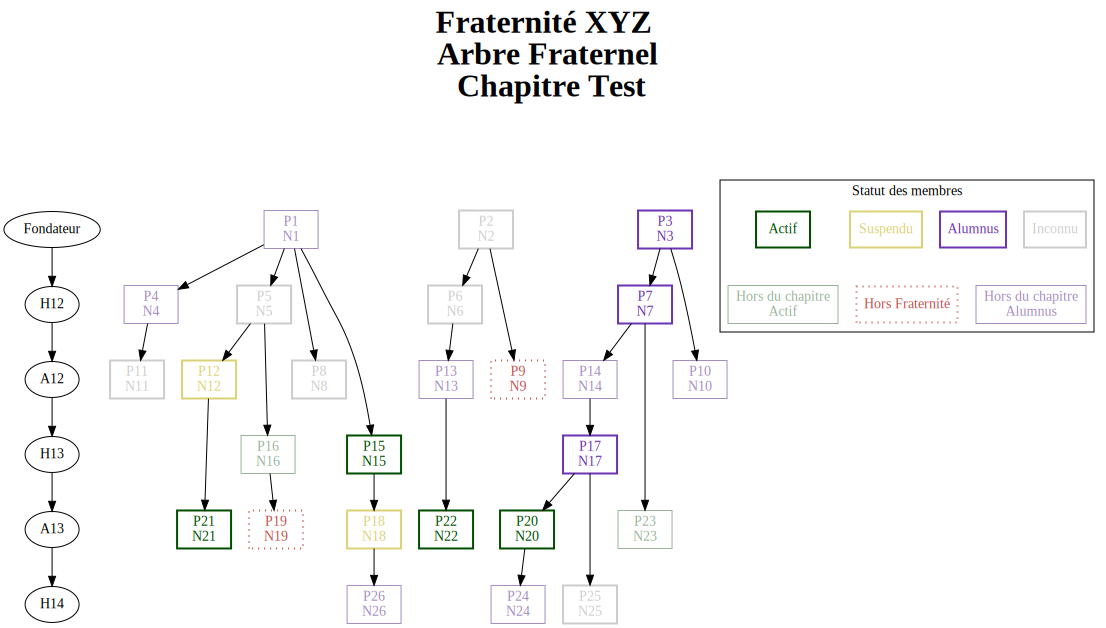

In [34]:
dot